In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Initialization

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

In [2]:
# Read in labels file
df_labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
df_labels.info()
display(df_labels.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


## EDA

In [4]:
# Descriptive statistics
df_labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


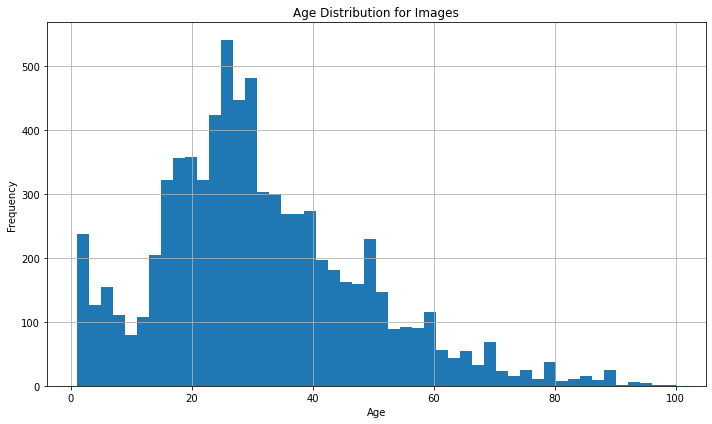

In [5]:
# Age distribution in dataset
df_labels['real_age'].hist(bins=50, figsize=(10,6))
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution for Images')
plt.tight_layout()
plt.show()

Ages range from 1 to 100. Majority of ages are between 20-40. Mean age of 31 is slightly higher than median age of 29, otherwise not heavily skewed.

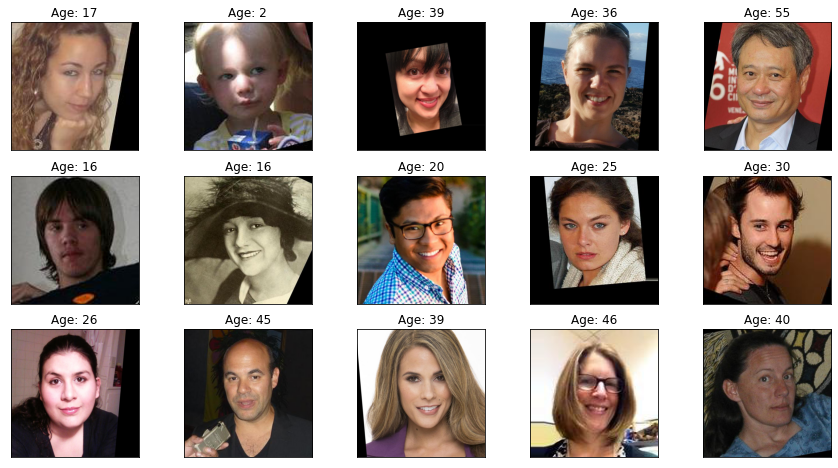

In [6]:
# Take 15 random files
sample = df_labels.sample(15)
sample_filename = sample['file_name'].tolist()
sample_realage = sample['real_age'].tolist()

# Display 15 images
fig = plt.figure(figsize=(15, 8))
for i, name in enumerate(sample_filename):
    fig.add_subplot(3, 5, i+1)
    array = np.array(Image.open('/datasets/faces/final_files/' + name))
    plt.title(f'Age: {sample_realage[i]}')
    plt.imshow(array)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout
plt.show()

### Findings

Ages range from 1 to 100. Majority of ages are between 20-40. Mean age of 31 is slightly higher than median age of 29, otherwise not heavily skewed.

Appears to be a large mixture of photos. There are headshots, full body shots, and from different angles towards the face. Images are cropped and/or have been rotated as well to focus in on the face of the individual.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

In [7]:
def load_train(path):
    """
    It loads the train part of dataset from path
    """
    df_labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale = 1/255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        class_mode='raw',
        batch_size=32,
        subset='training',
        seed=11
    )
    return train_gen_flow

In [8]:
def load_test(path):
    """
    It loads the validation/test part of dataset from path
    """
    df_labels = pd.read_csv(path + 'labels.csv')
    
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    
    test_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=df_labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        class_mode='raw',
        batch_size=32,
        subset='validation',
        seed=11
    )
    return test_gen_flow

In [9]:
def create_model(input_shape):
    """
    It defines the model
    """
    backbone = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    model = Sequential()
    model.add(backbone)
    # dropout layer to prevent overfitting
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())

    # regression, 1 neuron needed
    model.add(Dense(units=1, activation='relu'))
    optimizer=Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    print(model.summary())
    return model

In [10]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Trains the model given the parameters
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model

## Prepare the Script to Run on the GPU Platform

In [11]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Model: "sequential"

| Layer (type)            | Output Shape           | Param #     |
| ------------------------|------------------------|-------------|
| resnet50 (Model)        | (None, 7, 7, 2048)     | 23587712    |
| dropout (Dropout)       | (None, 7, 7, 2048)     | 0           |
| global_average_pooling2d| (None, 2048)           | 0           |
| dense (Dense)           | (None, 1)              | 2049        |  
Total params:    | |23,589,761
Trainable params: ||23,536,641
Non-trainable params:|| 53,120

Train for 178 steps, validate for 60 steps \
Epoch 1/20\
178/178 - 42s - loss: 10.9424 - mae: 10.9420 - val_loss: 14.5886 - val_mae: 14.6244\
Epoch 2/20\
178/178 - 34s - loss: 8.4822 - mae: 8.4820 - val_loss: 17.3998 - val_mae: 17.4447\
Epoch 3/20\
178/178 - 34s - loss: 7.5508 - mae: 7.5505 - val_loss: 19.1834 - val_mae: 19.2234\
Epoch 4/20\
178/178 - 35s - loss: 6.6918 - mae: 6.6916 - val_loss: 11.4831 - val_mae: 11.4424\
Epoch 5/20\
178/178 - 35s - loss: 6.0250 - mae: 6.0251 - val_loss: 8.2098 - val_mae: 8.2364\
Epoch 6/20\
178/178 - 34s - loss: 5.5137 - mae: 5.5135 - val_loss: 9.1804 - val_mae: 9.2085\
Epoch 7/20\
178/178 - 35s - loss: 5.1125 - mae: 5.1124 - val_loss: 8.6852 - val_mae: 8.7005\
Epoch 8/20\
178/178 - 35s - loss: 4.5707 - mae: 4.5708 - val_loss: 7.8167 - val_mae: 7.8029\
Epoch 9/20\
178/178 - 35s - loss: 4.4028 - mae: 4.4032 - val_loss: 7.5452 - val_mae: 7.5569\
Epoch 10/20\
178/178 - 35s - loss: 3.9666 - mae: 3.9665 - val_loss: 8.8793 - val_mae: 8.8945\
Epoch 11/20\
178/178 - 35s - loss: 3.7312 - mae: 3.7313 - val_loss: 8.7843 - val_mae: 8.8168\
Epoch 12/20\
178/178 - 34s - loss: 3.6041 - mae: 3.6036 - val_loss: 7.2672 - val_mae: 7.2707\
Epoch 13/20\
178/178 - 35s - loss: 3.4842 - mae: 3.4845 - val_loss: 8.8893 - val_mae: 8.8662\
Epoch 14/20\
178/178 - 34s - loss: 3.2097 - mae: 3.2100 - val_loss: 7.3658 - val_mae: 7.3819\
Epoch 15/20\
178/178 - 34s - loss: 3.0796 - mae: 3.0797 - val_loss: 7.2732 - val_mae: 7.2764\
Epoch 16/20\
178/178 - 34s - loss: 2.9032 - mae: 2.9030 - val_loss: 7.7236 - val_mae: 7.7143\
Epoch 17/20\
178/178 - 34s - loss: 2.7936 - mae: 2.7938 - val_loss: 7.1630 - val_mae: 7.1722\
Epoch 18/20\
178/178 - 35s - loss: 2.6852 - mae: 2.6852 - val_loss: 7.3150 - val_mae: 7.2886\
Epoch 19/20\
178/178 - 35s - loss: 2.6930 - mae: 2.6933 - val_loss: 7.0734 - val_mae: 7.0696\
Epoch 20/20\
178/178 - 34s - loss: 2.5772 - mae: 2.5771 - val_loss: 7.1373 - val_mae: 7.1530

60/60 - 9s - loss: 7.1373 - mae: 7.1530\
Test MAE: 7.1530

## Conclusions

The trained model was able to achieve a MAE of 7.15, meeting our target metric of under 8. This was achieved using ResNet50, with Adam optimizer, and a mean absolute error loss function. We can predict age of a person +/- 7.15 years.

The lowest MAE reached is 5.4 published in this paper: http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf.